# Getting started


First the imports.


In [ ]:
from typing import Literal

from pepme.base import (
    Metric,
    MetricResult,
    barplot,
    combine_metric_dataframes,
    compute_metrics,
    random_subset,
    read_fasta_file,
    show_table,
    write_to_fasta_file,
)
from pepme.gravy import Gravy
from pepme.novelty import Novelty

## Basics


Let's define the sequences to use and the metrics to compute. Some sequences will be loaded from fasta files, others are hard-coded.


First let's write a fasta file with random sequences to disk.


In [ ]:
RANDOM_SEQUENCES_PATH = "../data/random.fasta"

In [ ]:
random_sequences = ["KKKKK", "PLUQ", "RKSPL"]

write_to_fasta_file(random_sequences, RANDOM_SEQUENCES_PATH)

UniProt contains a lot of sequences. To speed-up the metric computations, we will only use a (random) subset of the UniProt sequences.


In [ ]:
sequences = {
    "Random": read_fasta_file(RANDOM_SEQUENCES_PATH),
    "UniProt": random_subset(["KKWQ", "RKSPL", "RASD"], n_samples=2, seed=42),
    "HydrAMP": ["MMRK", "RKSPL", "RRLSK"],
    "hyformer": ["MKQW", "RKSPL"],
}

metrics = [
    Novelty(reference=["KKW", "RKSPL"]),
    Novelty(reference=sequences["Random"], reference_name="Random"),
    Gravy(),
]

df = compute_metrics(sequences, metrics)

Output()

Let's look at the results.


In [ ]:
df

Novelty           Novelty (Random)               Gravy          
             value deviation            value deviation     value deviation
Random    0.666667       NaN         0.000000       NaN  0.466112  0.410875
UniProt   1.000000       NaN         1.000000       NaN  0.249478  0.249871
HydrAMP   0.666667       NaN         0.666667       NaN  0.499498  0.081649
hyformer  0.500000       NaN         0.500000       NaN  0.324480  0.075057

... let's make it nicer to look at.


In [ ]:
show_table(df, decimals=2)

,Novelty↑,Novelty (Random)↑,Gravy
Random,0.67,0.00,0.47±0.41
UniProt,1.00,1.00,0.25±0.25
HydrAMP,0.67,0.67,0.50±0.08
hyformer,0.50,0.50,0.32±0.08


We are particularly interested in the following metric.


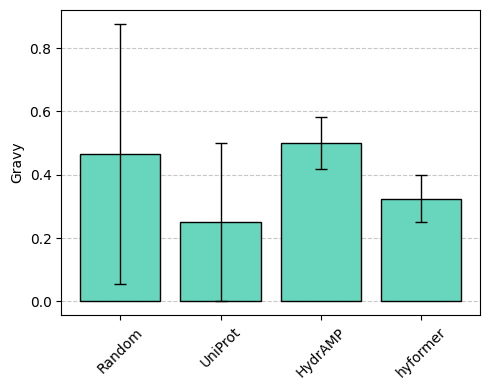

In [ ]:
barplot(df, "Gravy")

That it all for the basic usage of pepme. Let's look at some more advanced features!


## Advanced


In the advanced section, we show how to combine multiple metric dataframes into one and how to create your own metric. pepme's `combine_metric_dataframes` can combine metric dataframes with different sequences and/or metrics.


Let's compute some metrics for the three sets of sequences.


In [ ]:
df1 = compute_metrics(
    sequences={
        "s1": ["KKKKK", "PLUQ", "RKSPL"],
        "s2": random_subset(["KKWQ", "RKSPL", "RASD"], n_samples=2, seed=42),
        "s3": ["MMRK", "RKSPL", "RRLSK"],
        "s4": ["MKQW", "RKSPL"],
    },
    metrics=[
        Novelty(reference=["KKW", "RKSPL"]),
        Novelty(reference=["RASD", "KKKQ", "LPTUY"], reference_name="Random"),
    ],
    verbose=False,
)

df2 = compute_metrics(
    sequences={"s4": ["MKQW", "RKSPL"], "s5": ["MKQW"]},
    metrics=[Gravy()],
    verbose=False,
)

df3 = compute_metrics(
    sequences={"s6": ["MKQW", "RKSPL"]},
    metrics=[Gravy(), Novelty(reference=["KKW", "RKSPL"])],
    verbose=False,
)

Let's combine the dataframes.


In [ ]:
df = combine_metric_dataframes([df1, df2, df3])

In [ ]:
df

Novelty           Novelty (Random)               Gravy          
       value deviation            value deviation     value deviation
s1  0.666667       NaN              1.0       NaN       NaN       NaN
s2  1.000000       NaN              0.5       NaN       NaN       NaN
s3  0.666667       NaN              1.0       NaN       NaN       NaN
s4  0.500000       NaN              1.0       NaN  0.324480  0.075057
s5       NaN       NaN              NaN       NaN  0.249422  0.000000
s6  0.500000       NaN              NaN       NaN  0.324480  0.075057

... let's make it nicer to look at.


In [ ]:
show_table(df, decimals=[3, 2, 1], color="#d66868")

,Novelty↑,Novelty (Random)↑,Gravy
s1,0.667,1.00,-
s2,1.000,0.50,-
s3,0.667,1.00,-
s4,0.500,1.00,0.3±0.1
s5,-,-,0.2±0.0
s6,0.500,-,0.3±0.1


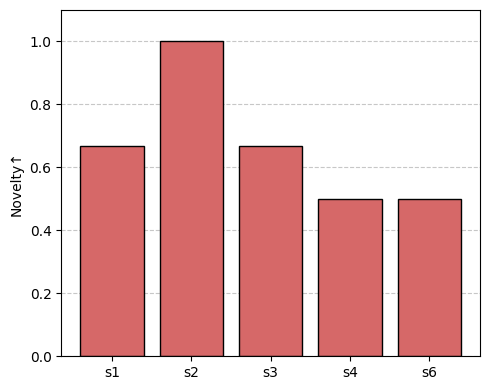

In [ ]:
barplot(df, "Novelty", color="#d66868", ylim=(0.0, 1.1), x_ticks_label_rotation=0.0)

Notice missing values (e.g., s5) are not shown in the barplot.

You can also intergrate your own metrics into pepme through the `Metric` interface as shown below.


In [ ]:
class MyMetric(Metric):
    def __init__(self, amino_acid: str, minimize: bool = True):
        self.amino_acid = amino_acid
        self.minimize = minimize

    def __call__(self, sequences: list[str]) -> MetricResult:
        aa_count = sum([seq.count(self.amino_acid) for seq in sequences])
        aa_total = sum([len(sequence) for sequence in sequences])
        return MetricResult(aa_count / aa_total)

    @property
    def name(self) -> str:
        return f"{self.amino_acid}-frequency"

    @property
    def objective(self) -> Literal["minimize", "maximize", "ambiguous"]:
        return "minimize" if self.minimize else "maximize"

Let's use our new metric.

In [ ]:
df = compute_metrics(
    sequences={
        "hyformer": ["MKQW", "RKSPL", "RASD"],
        "HydrAMP": ["MKQW", "RKSPL"],
        "Random": ["AAAA", "PPPPP"],
    },
    metrics=[
        MyMetric(amino_acid="K", minimize=False),
        MyMetric(amino_acid="R", minimize=True),
    ],
)

show_table(df, color="#e07fe1")

Output()

,K-frequency↑,R-frequency↓
hyformer,0.15,0.15
HydrAMP,0.22,0.11
Random,0.00,0.00


This is all there is to pepme! 🎉
